In [28]:
import compton.Dataloader as dl
from compton.Functions import *
from compton.Analysis import *
from positron.Analysis import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import pandas as pd

,Channel,Energy (keV),Counts
0,1,0.755920,0
1,2,1.511840,0
2,3,2.267760,0
3,4,3.023679,0
4,5,3.779599,0


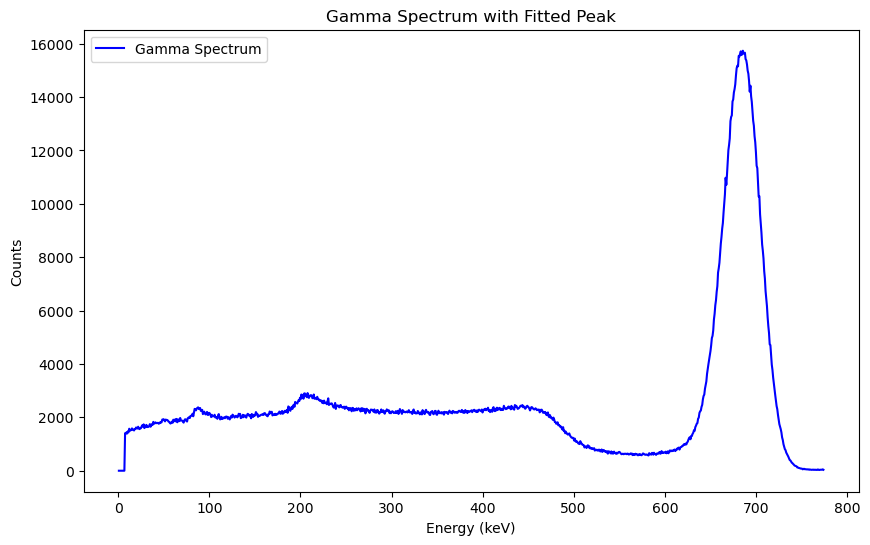

In [29]:
# Load data
control = dl.load_gamma_count('../Databases/Compton/BBL_S0_A0.csv')
display(control.head())

data = control.values  # Convert DataFrame to NumPy array
energy = control['Energy (keV)'].to_numpy()
counts = control['Counts'].to_numpy()

# Plot raw data
plt.figure(figsize=(10, 6))
plt.plot(energy, counts, label='Gamma Spectrum', color='blue')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.title('Gamma Spectrum with Fitted Peak')
plt.legend()
plt.show()


[-871.91910942 1565.98320894   29.46324446  488.43852842]


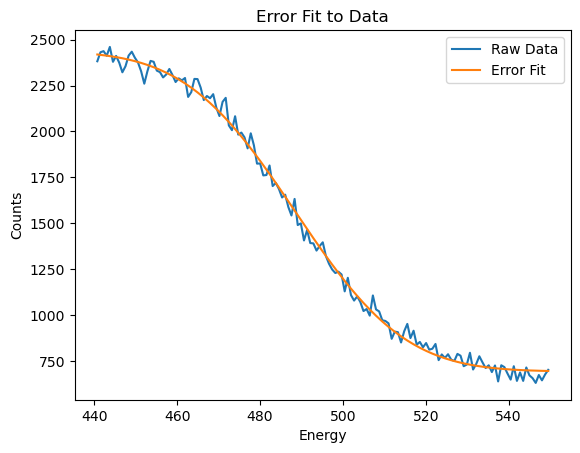

error function center: 488.4385284171225, uncertainty 0.30720389279248217


In [30]:
#Trim ROi for error function regression fit on compton edge
edge_trim_df = trim_df(control, 440, 550)
popt, pcov = error_fit(edge_trim_df)
print(popt)
plot_error_fit(edge_trim_df,)
print(f"error function center: {popt[3]}, uncertainty {np.sqrt(pcov[3][3])}")


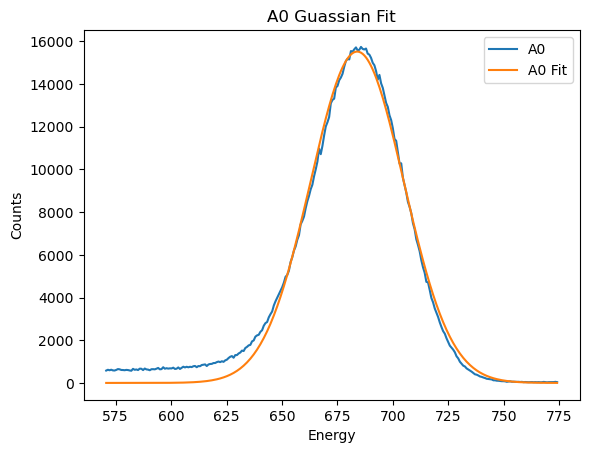

,Angle,Mean,Sigma,Unc Mean,Unc Sigma
0,0,683.890229,21.057968,0.128233,0.128233


In [31]:
#trim ROI for guassian fit
guass_trim_df = trim_df(control, 570, 800)
baseline = run_all_S1_fits([guass_trim_df])
plot_guassian_fit(guass_trim_df)
display(baseline)
E = baseline['Mean'][0]
sig_E = baseline['Unc Mean'][0]

Next, we have to use the location of these peaks and their known values to obtain the linear calibration curve for the energies

0.880012807695319 60.16783922107818


/home/lucas/repos/advanced_exp/positron/Analysis.py:111: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(linear, x, y,)


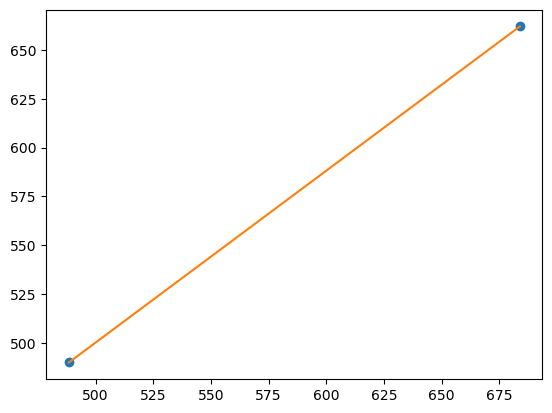

In [32]:
baseline.loc[1] = [0, popt[3], None, None, None]
knowns = [662, 490]
slope, intercept, _, _ = fit_plot_calibration(baseline, knowns)
print(slope, intercept,)

The following cell runs analysis of each of the S1 datasets (scattering material included) for each angle, reporting in a dataframe.

In [33]:
angles = range(0,140, 10)
all_info = []
calibration_params = [slope, intercept]
for ii in range(len(angles)):
    data = dl.load_gamma_count('../Databases/Compton/BBL_S1_A' + str(angles[ii]) + '.csv', rescale = calibration_params) #note the data is recalibrated now by energy level
    all_info.append(data)
#if you want to NOT recalibrate the data, you should set rescale to None, and set mins and maxes in the next cell to minimum_energy_s1 WITHOUT running it through the linear function
#plot_all(all_info, minimum_energy_S1())

The next cell gathers peak data by fitting a guassian to the manualy assigned roi in each of the angles. The problem is that the uncertainty in the mean that it assigns is rather small, unreasonably so. I am not sure if it makes sense to interpret the uncertainty in the fit estimate of the mean as the standard error.

In [34]:
mins = linear(np.array(minimum_energy_S1()), calibration_params[0], calibration_params[1])
maxs = linear(np.array(maximum_energy_S1()), calibration_params[0], calibration_params[1])
trimmed_info = trim_S1_dfs(all_info, mins, maxs)
peaks = run_all_S1_fits(trimmed_info)
display(peaks.head())

,Angle,Mean,Sigma,Unc Mean,Unc Sigma
0,0,658.223575,17.907089,0.103397,0.136474
1,10,658.528987,17.932930,0.078270,0.103446
2,20,654.312687,26.086518,0.776896,0.814192
3,30,551.242587,51.568830,1.023053,1.892784
4,40,514.013609,38.576086,0.803471,1.095885


This next cell allows you to plot all the graphs if you so desire, to see the fits

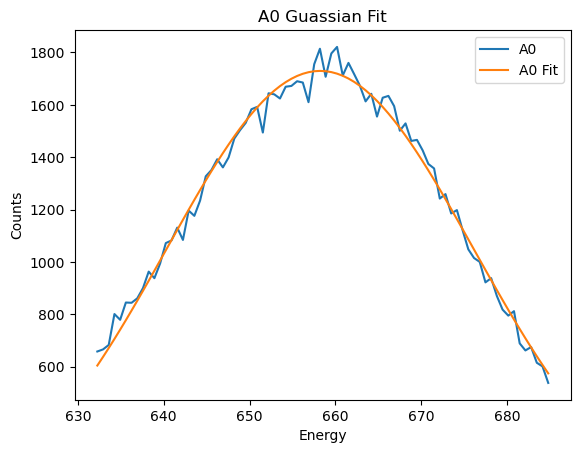

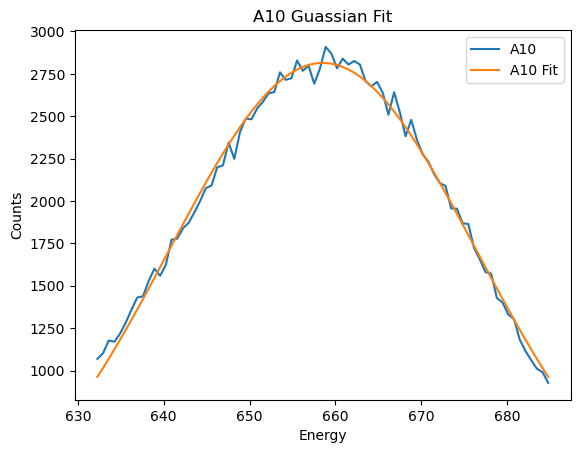

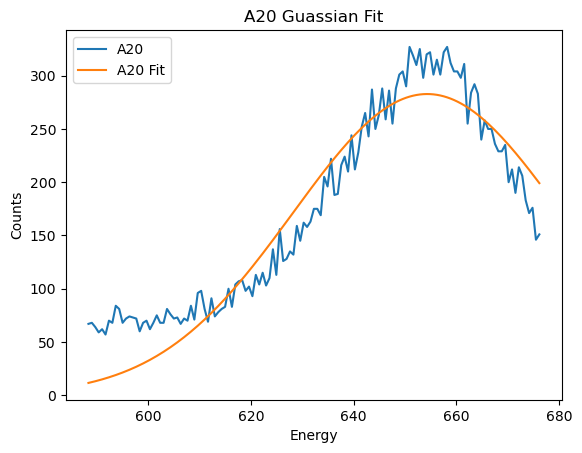

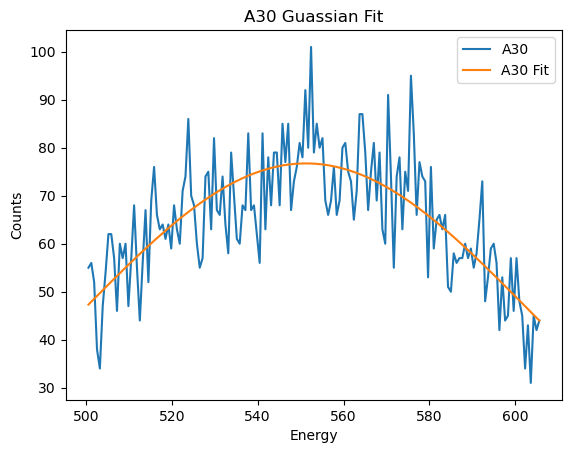

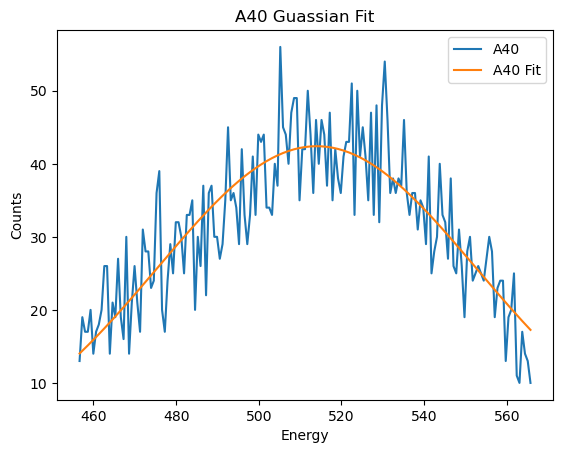

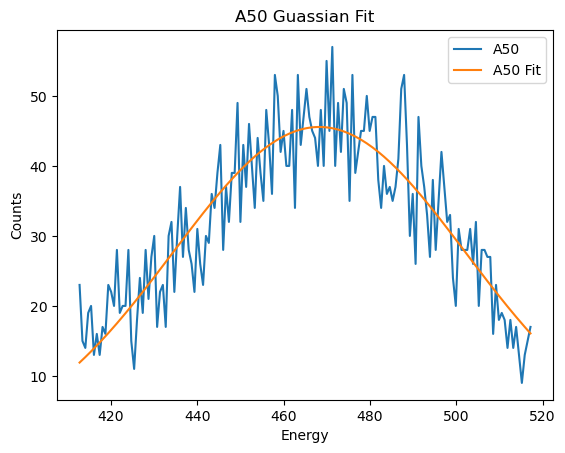

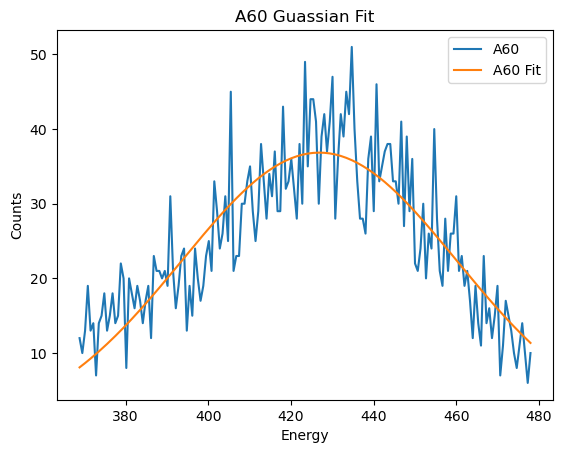

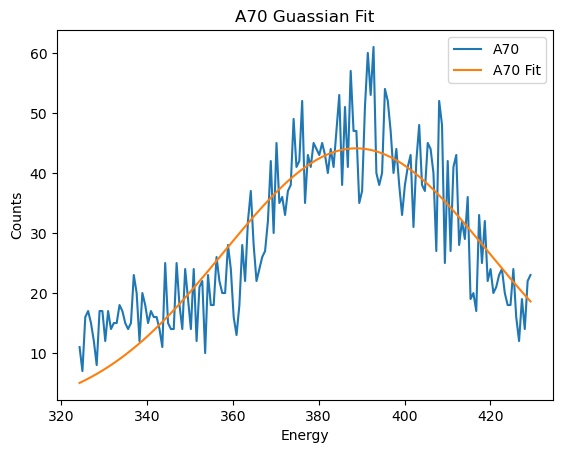

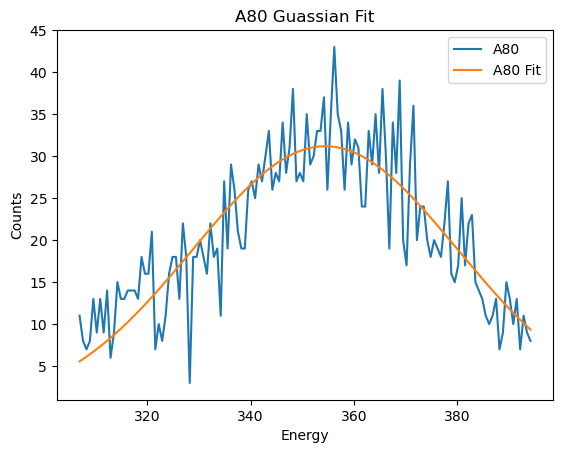

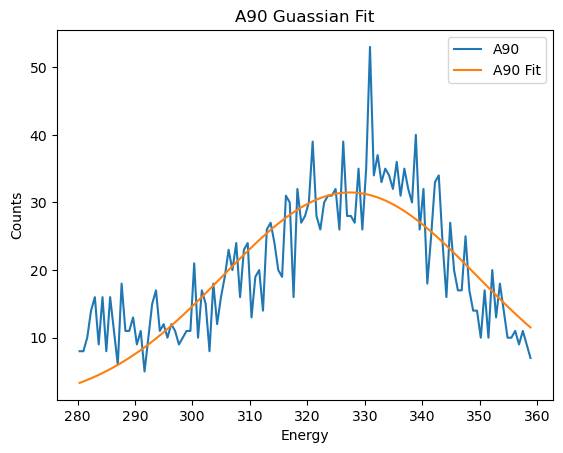

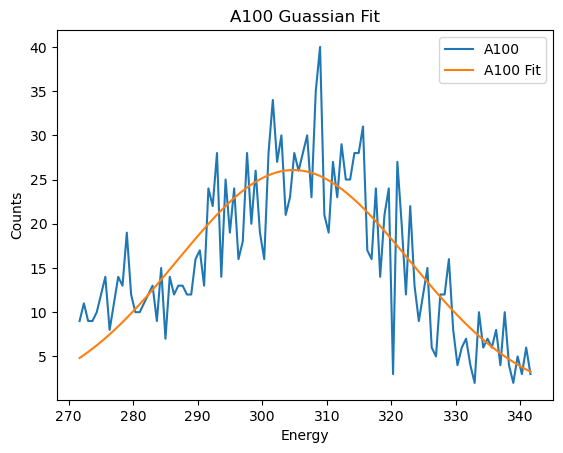

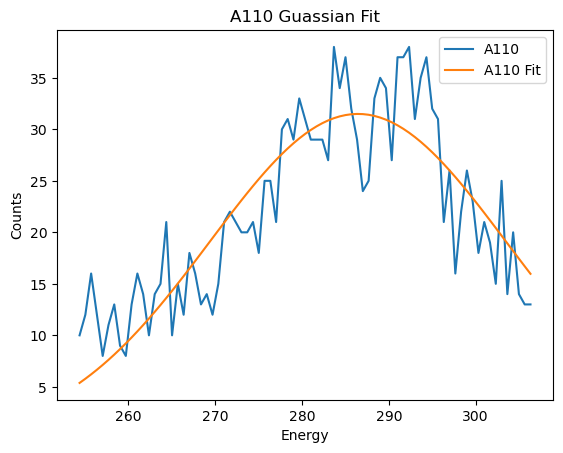

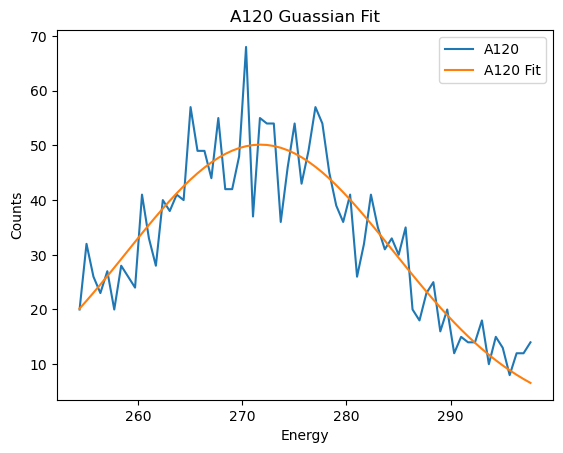

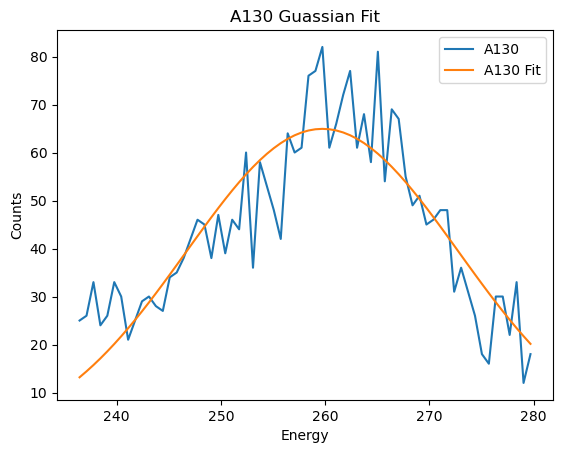

In [37]:
plot_all_S1_fits(trimmed_info)

Finally, we have to plot E/E' over 1/cos(theta)
our code starts by calculating E/E'(with uncertainty)and 1-cos(theta) as new Collumns, then runs a fit on the data and plots it.

,Angle,Mean,Sigma,Unc Mean,Unc Sigma,E/E',Unc E/E',1-cos(theta)
0,0,658.223575,17.907089,0.103397,0.136474,1.038994,0.000235,0.000000
1,10,658.528987,17.932930,0.078270,0.103446,1.038512,0.000214,0.015192
2,20,654.312687,26.086518,0.776896,0.814192,1.045204,0.001150,0.060307
3,30,551.242587,51.568830,1.023053,1.892784,1.240634,0.001504,0.133975
4,40,514.013609,38.576086,0.803471,1.095885,1.330491,0.001183,0.233956


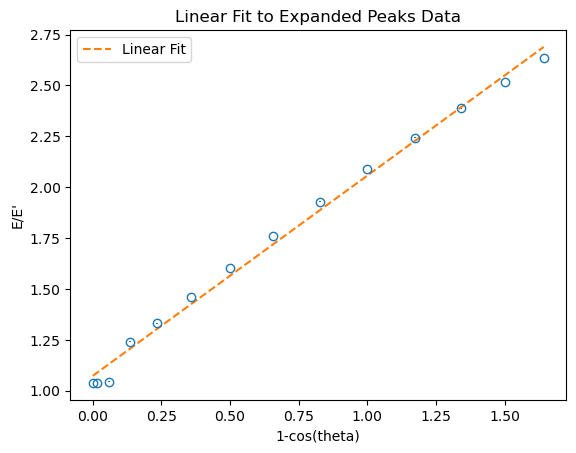

0.9836246757014427 0.021872014597313746 1.073295447767826 0.019118735241768582


In [36]:
peaks = dl.expand_df(peaks, E, sig_E)
display(peaks.head())
slope, unc_slope, intercept, unc_intercept = linear_fit_plot(peaks[:])
print(slope, unc_slope, intercept, unc_intercept)